In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Creating db file from csv
disk_engine = create_engine('sqlite:///train.db')  


df= pd.read_csv("/content/drive/MyDrive/Quora/final_features.csv")
df[0:100000].to_sql('data', disk_engine, if_exists='append')
     


100000

In [4]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [5]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [6]:
conn_r = create_connection(read_db)
data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 10001;", conn_r)
conn_r.commit()
conn_r.close()

In [7]:
data.head()

,index,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,22161,22161,22161,0,0.333322,0.199996,0.749981,0.428565,0.444440,0.399996,...,1.221500,0.318931,-0.607516,1.209740,-3.346711,-1.793120,0.379157,0.992432,0.251408,-0.722210
1,89639,89639,89639,0,0.999950,0.499988,0.999975,0.799984,0.999983,0.666659,...,-0.912033,1.807053,-0.398482,-2.700661,-1.080358,-0.021000,2.105288,-0.801772,2.081748,-2.500517
2,23783,23783,23783,0,0.666644,0.399992,0.749981,0.499992,0.714276,0.454541,...,-1.603781,-1.836924,-2.470417,0.979198,-2.148682,-2.851997,0.779997,1.331418,0.350225,2.868719
3,86454,86454,86454,1,0.666644,0.499988,0.999975,0.571420,0.857131,0.545450,...,1.694657,0.584885,2.344996,1.684966,-3.477607,-2.318253,3.834207,-3.777146,3.272229,1.018320
4,3663,3663,3663,1,0.999900,0.999900,0.999980,0.833319,0.857131,0.857131,...,-1.435808,0.003272,-1.740983,-0.123314,-2.558745,-1.263838,0.617316,-0.138613,-0.381818,0.276028


In [8]:
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [9]:
# SQL entries from database were read as string; converting them to numeric
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)

In [10]:
y_true = list(map(int, y_true.values))

Confusion, Precision and Recall Matrices to validate performance over True and False categories

In [14]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i, predicted as class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Test - Train Split

In [15]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7000, 218)
Number of data points in test data : (3000, 218)


In [16]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.626 Class 1:  0.374
---------- Distribution of output variable in test data ----------
Class 0:  0.626 Class 1:  0.374


Model - Random Predictor

Log loss on Test Data using Random Model 0.8599982729917173


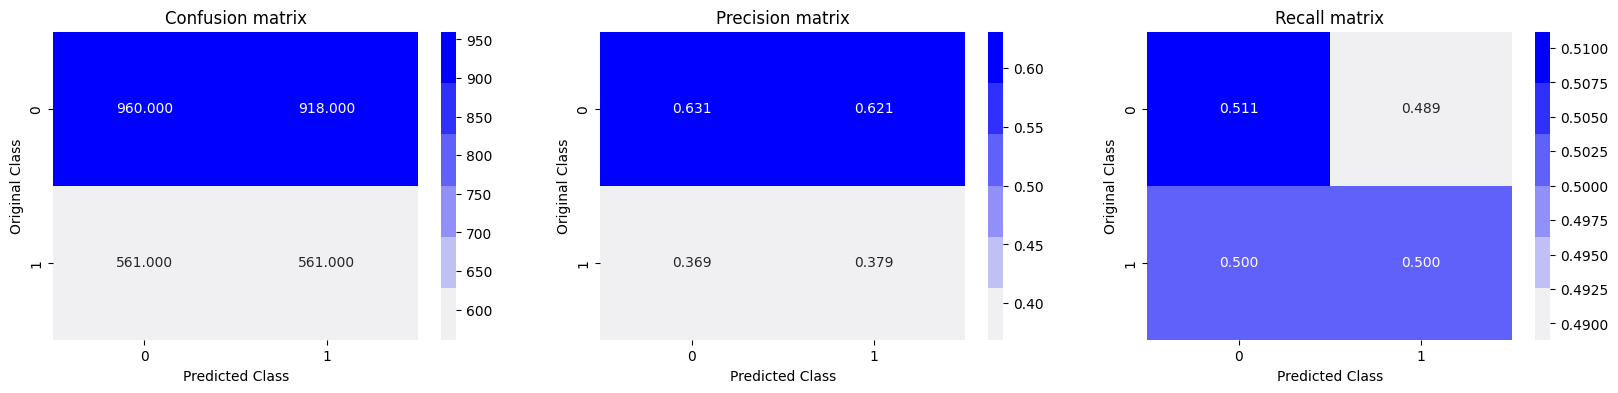

In [18]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))
predicted_y =np.argmax(predicted_y, axis=1)


plot_confusion_matrix(y_test, predicted_y)
plt.show()
     



Logistic Regression with Hyperparameter Tuning

For values of alpha =  1e-05 The log loss is: 0.4596266945410163
For values of alpha =  0.0001 The log loss is: 0.4504495301788141
For values of alpha =  0.001 The log loss is: 0.45108680650380273
For values of alpha =  0.01 The log loss is: 0.44961118113520526
For values of alpha =  0.1 The log loss is: 0.4517094681388693
For values of alpha =  1 The log loss is: 0.47348007156695043
For values of alpha =  10 The log loss is: 0.5197450714935329


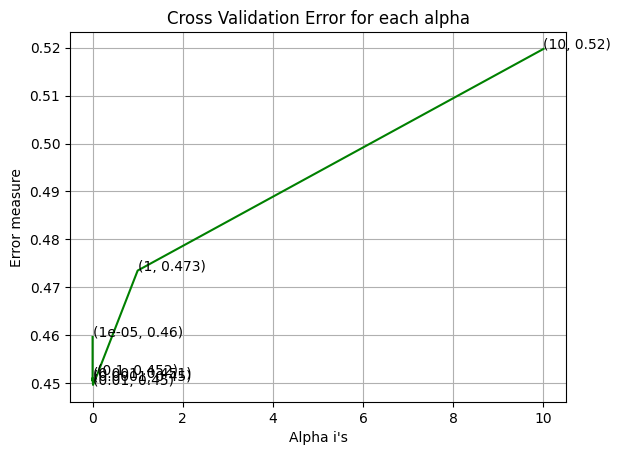

For values of best alpha =  0.01 The train log loss is: 0.4239702109819652
For values of best alpha =  0.01 The test log loss is: 0.44961118113520526
Total number of data points : 3000


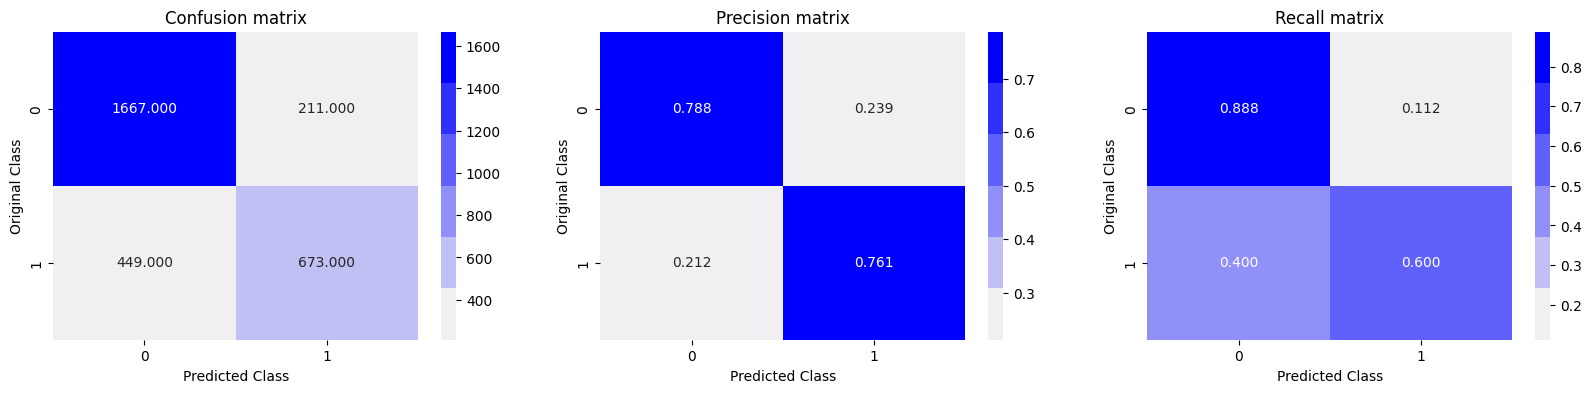

In [19]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Linear SVM with Hyperparameter Tuning

For values of alpha =  1e-05 The log loss is: 0.5602769591459958
For values of alpha =  0.0001 The log loss is: 0.4818231930037984
For values of alpha =  0.001 The log loss is: 0.5058598266032185
For values of alpha =  0.01 The log loss is: 0.5190216056682047
For values of alpha =  0.1 The log loss is: 0.4903832427573999
For values of alpha =  1 The log loss is: 0.5687001190153685
For values of alpha =  10 The log loss is: 0.6543785010049346


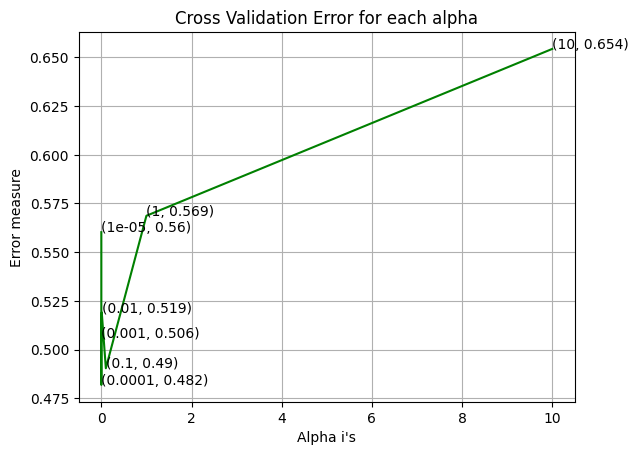

For values of best alpha =  0.0001 The train log loss is: 0.45052587198953475
For values of best alpha =  0.0001 The test log loss is: 0.4818231930037984
Total number of data points : 3000


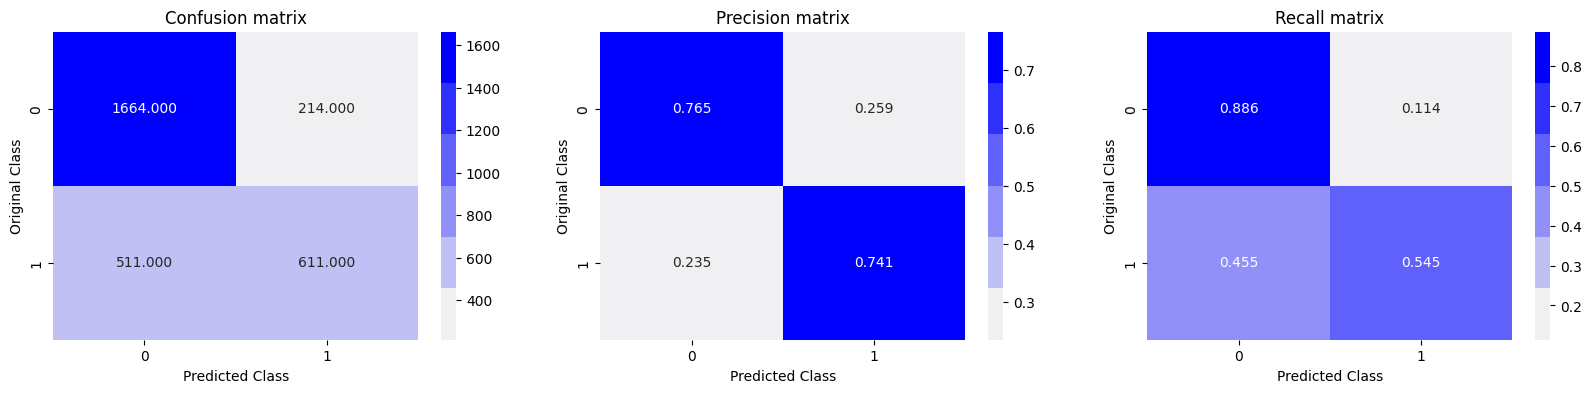

In [20]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)  

XGboost with Hyperparameter Tuning

In [21]:
import xgboost as xgb
param_grid = {"max_depth":[x for x in range(2,10)],"n_estimators":[50,100,150,200,300,400,500]}

In [22]:
model = model_selection.RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=30,scoring='neg_log_loss',cv=3,n_jobs=-1)

In [23]:
model.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=25, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [50, 100, 150, 200, 300,
                                                         400, 500]},
                   scoring='neg_log_loss')

In [24]:
model.best_params_

{'n_estimators': 100, 'max_depth': 2}

In [25]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=2,n_estimators=100)

In [26]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=25, ...)

Train log loss =  0.3067182353291233  Test log loss =  0.3953464374869656


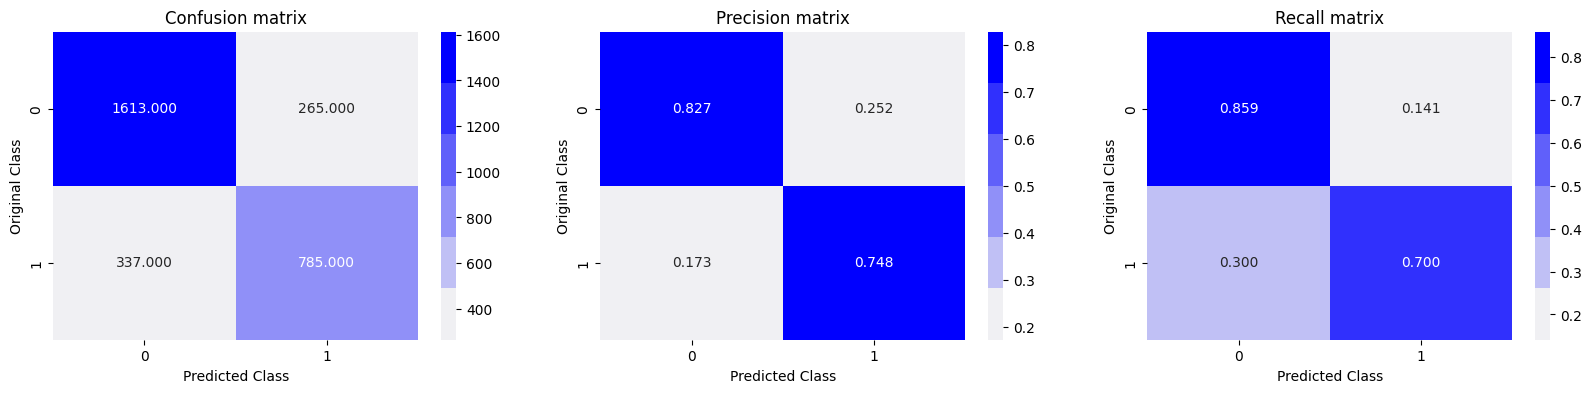

In [27]:
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)